In [165]:
import numpy as np

from tg.projects.punct.context_builder import PunctContextBuilder, PunctContextBuilderWithLeak
from tg.common.ml import batched_training as bt
from tg.common.ml import dft
from tg.common import DataBundle
from tg.grammar_ru.common import Loc
from tg.common.ml.batched_training import context as btc
from tg.common.ml.batched_training import factories as btf

In [166]:
db = DataBundle.load(Loc.bundles_path/'punct/550k')

In [167]:
idb = bt.IndexedDataBundle(
    index_frame=db.index,
    bundle=db
)

In [168]:
context_builder = PunctContextBuilder(
    include_zero_offset=True,
    left_to_right_contexts_proportion=0.5
)

In [169]:
pymorphy_extractor = (
    bt
    .PlainExtractor
    .build('pymorphy')
    .index()
    .join('pymorphy', on_columns='another_word_id')
    .apply(
        transformer=dft.DataFrameTransformerFactory.default_factory(),
    )
)

In [170]:
def create_assembly_point(context_extractor, context_builder, context_length=5):
    ap = btc.ContextualAssemblyPoint(
        name='features',
        context_builder=context_builder,
        extractor=context_extractor,
        context_length=6
    )
    ap.reduction_type = ap.reduction_type.Dim3Folded

    return ap

In [171]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer


class DataFrameLabelBinarizer():
    def __init__(self, column_name):
        self.column_name = column_name
        self.encoder = LabelBinarizer()

    def fit(self, df):
        self.encoder.fit(df[self.column_name])

        return self

    def transform(self, df):
        transformed_columns = self.encoder.transform(df[self.column_name])
        if transformed_columns.shape[1] == 1:
            result = pd.DataFrame(index=df.index, columns=list(self.encoder.classes_[0]), data=transformed_columns)
        else:
            result = pd.DataFrame(index=df.index, columns=self.encoder.classes_, data=transformed_columns)

        return result

In [172]:
def create_label_extractor():
    label_extractor = (
        bt.PlainExtractor
        .build(btf.Conventions.LabelFrame)
        .index()
        .apply(take_columns='target_word', transformer=DataFrameLabelBinarizer('target_word'))
    )

    return label_extractor

In [173]:
le = create_label_extractor()
le.fit_extract(idb)

,",",:,no,—
sample_id,,,,
23,0,0,1,0
33,0,0,1,0
49,0,1,0,0
151,1,0,0,0
167,0,1,0,0
...,...,...,...,...
642527,0,0,0,1
642554,0,0,0,1
642764,0,0,0,1


In [174]:
import torch


class PunctNetwork(torch.nn.Module):
    def __init__(self, head, hidden_size, out_size):
        super(PunctNetwork, self).__init__()
        self.head = head
        self.tail = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, out_size),
            torch.nn.Softmax(1)
        )
        
    def forward(self, batch):
        return self.tail(self.head(batch))


class PunctNetworkFactory:
    def __init__(self, assembly_point, out_size):
        self.assembly_point = assembly_point
        self.out_size = out_size
        
    def __call__(self, batch):
        head_factory = self.assembly_point.create_network_factory()
        head = head_factory(batch)

        return PunctNetwork(head, self.assembly_point.hidden_size, self.out_size)

* Добавим стратификацию

2023-03-30 13:48:03.367648 INFO: Training starts. Info: {}
2023-03-30 13:48:03.369864 INFO: Ensuring/loading bundle. Bundle before:
{'index': {'shape': (9980, 7), 'index_name': 'sample_id'}, 'src': {'shape': (552001, 17), 'index_name': None}, 'pymorphy': {'shape': (552001, 16), 'index_name': 'word_id'}, 'index_trunc': {'shape': (107179, 6), 'index_name': 'sample_id'}}
2023-03-30 13:48:03.372454 INFO: Bundle loaded
{'index': {'shape': (9980, 7), 'index_name': 'sample_id', 'columns': ['word_id', 'sentence_id', 'label', 'reference', 'target_word', '...'], 'index': [23, 33, 49, 151, 167, '...']}, 'src': {'shape': (552001, 17), 'index_name': None, 'columns': ['word_id', 'sentence_id', 'word_index', 'paragraph_id', 'word_tail', '...'], 'index': [0, 1, 2, 3, 4, '...']}, 'pymorphy': {'shape': (552001, 16), 'index_name': 'word_id', 'columns': ['normal_form', 'alternatives', 'score', 'delta_score', 'POS', '...'], 'index': [0, 1, 2, 3, 4, '...']}, 'index_trunc': {'shape': (107179, 6), 'index_name

<AxesSubplot:>

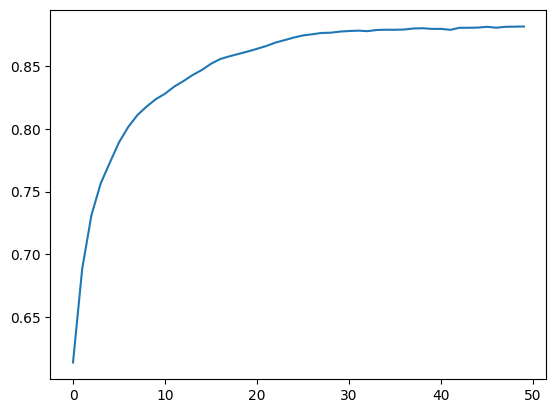

In [219]:
import pandas as pd
from sklearn.metrics import roc_auc_score

from tg.common.ml.batched_training.factories import CtorAdapter


punct_features_assembly_point = create_assembly_point(pymorphy_extractor, context_builder)
punct_features_assembly_point.hidden_size = 50
punct_features_assembly_point.dim_3_network_factory.network_type = btc.Dim3NetworkType.LSTM

punct_network_factory = PunctNetworkFactory(punct_features_assembly_point, out_size=4)

punct_label_extractor = create_label_extractor()


class PunctTrainingTask(btf.TorchTrainingTask):
    def __init__(self, features_assembly_point, factory, label_extractor):
        super(PunctTrainingTask, self).__init__()
        self.metric_pool = bt.MetricPool().add_sklearn(roc_auc_score)
        self.features_assembly_point = features_assembly_point
        self.factory = factory
        self.label_extractor = label_extractor
    
    def initialize_task(self, idb):
        self.setup_batcher(idb, [self.features_assembly_point.create_extractor(), self.label_extractor], stratify_by_column='target_word')
        self.setup_model(self.factory, ignore_consistancy_check=True)


task = PunctTrainingTask(
    punct_features_assembly_point,
    punct_network_factory,
    punct_label_extractor
)
task.settings.epoch_count = 50
task.settings.mini_batch_size = 200
task.loss_ctor = CtorAdapter('torch.nn:CrossEntropyLoss')
result = task.run(db)
pd.DataFrame(result['output']['history']).roc_auc_score_test.plot()

<AxesSubplot:>

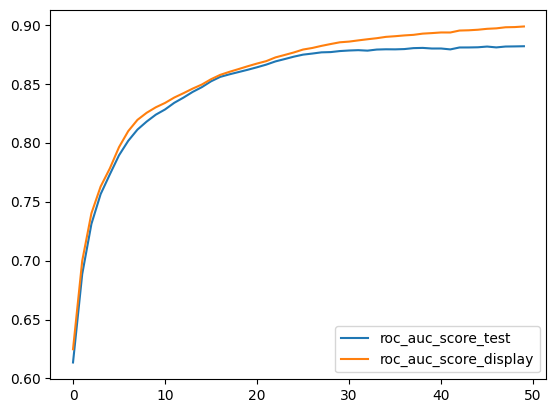

In [220]:
pd.DataFrame(result['output']['history'])[['roc_auc_score_test', 'roc_auc_score_display']].plot()

<AxesSubplot:>

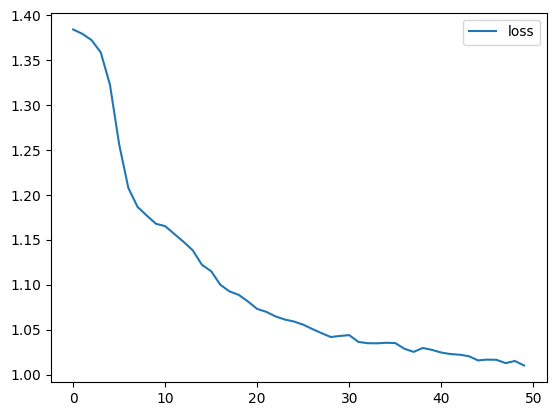

In [226]:
pd.DataFrame(result['output']['history'])[['loss']].plot()

In [227]:
output_df = result['output']['result_df']
test_predictions = output_df[output_df['stage'] == 'test']

true_columns = test_predictions.columns[test_predictions.columns.str.startswith('true')]
predicted_columns = test_predictions.columns[test_predictions.columns.str.startswith('predicted')]

true_classes = test_predictions[true_columns].values
predictions = test_predictions[predicted_columns].values

In [228]:
np.unique(np.argmax(predictions, axis=1))

array([0, 1, 2, 3])

In [229]:
output_df[output_df['true_:'] == 1]['predicted_:'].max()

0.9998918771743774

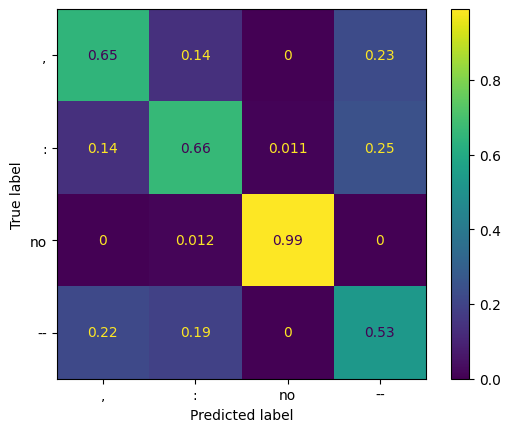

In [230]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(np.argmax(true_classes, axis=1), np.argmax(predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm / cm.sum(axis=0), display_labels=[',', ':', 'no', '--'])
disp.plot()